In [1]:
import os
import tensorflow as tf
import shutil
import pandas as pd
import sys
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

2025-06-06 21:24:10.002163: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-06 21:24:10.002292: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-06 21:24:10.139484: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
current_working_directory = os.getcwd()

# print output to the console
print(current_working_directory)


/kaggle/working


In [3]:
csv_path = '/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/meta.csv'
df_meta = pd.read_csv(csv_path)
dicom_data = pd.read_csv('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/dicom_info.csv')

In [4]:
image_dir = '/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg'
full_mammogram_images = dicom_data[dicom_data.SeriesDescription == 'full mammogram images'].image_path
cropped_images = dicom_data[dicom_data.SeriesDescription == 'cropped images'].image_path
roi_mask_images = dicom_data[dicom_data.SeriesDescription == 'ROI mask images'].image_path

full_mammogram_images = full_mammogram_images.apply(lambda x: x.replace('CBIS-DDSM/jpeg', image_dir))
cropped_images = cropped_images.apply(lambda x: x.replace('CBIS-DDSM/jpeg', image_dir))
roi_mask_images = roi_mask_images.apply(lambda x: x.replace('CBIS-DDSM/jpeg', image_dir))
full_mammogram_images.iloc[0]

'/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.248386742010678582309005372213277814849/1-249.jpg'

In [5]:
full_mammogram_dict = dict()
cropped_dict = dict()
roi_mask_dict = dict()

for dicom in full_mammogram_images:
    # print(dicom)
    key = dicom.split("/")[5]
    # print(key)
    full_mammogram_dict[key] = dicom
for dicom in cropped_images:
    key = dicom.split("/")[5]
    cropped_dict[key] = dicom
for dicom in roi_mask_images:
    key = dicom.split("/")[5]
    roi_mask_dict[key] = dicom

In [6]:
mass_train_data = pd.read_csv('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/mass_case_description_train_set.csv')
mass_test_data = pd.read_csv('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/mass_case_description_test_set.csv')
calc_train_data = pd.read_csv('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/calc_case_description_train_set.csv')
calc_test_data = pd.read_csv('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/calc_case_description_test_set.csv')

In [7]:
def fix_image_path_mass(dataset):
    for i, img in enumerate(dataset.values):
        img_name = img[11].split("/")[2]
        if img_name in full_mammogram_dict:
            dataset.iloc[i, 11] = full_mammogram_dict[img_name]

        img_name = img[12].split("/")[2]
        if img_name in cropped_dict:
            dataset.iloc[i, 12] = cropped_dict[img_name]

        img_name = img[13].split("/")[2]
        if img_name in roi_mask_dict:
            dataset.iloc[i, 13] = roi_mask_dict[img_name]

In [8]:
fix_image_path_mass(mass_test_data)
fix_image_path_mass(mass_train_data)

In [9]:
mass_train = mass_train_data.rename(columns={'left or right breast': 'left_or_right_breast',
                                           'image view': 'image_view',
                                           'abnormality id': 'abnormality_id',
                                           'abnormality type': 'abnormality_type',
                                           'mass shape': 'mass_shape',
                                           'mass margins': 'mass_margins',
                                           'image file path': 'image_file_path',
                                           'cropped image file path': 'cropped_image_file_path',
                                           'ROI mask file path': 'ROI_mask_file_path'})
mass_test = mass_test_data.rename(columns={'left or right breast': 'left_or_right_breast',
                                           'image view': 'image_view',
                                           'abnormality id': 'abnormality_id',
                                           'abnormality type': 'abnormality_type',
                                           'mass shape': 'mass_shape',
                                           'mass margins': 'mass_margins',
                                           'image file path': 'image_file_path',
                                           'cropped image file path': 'cropped_image_file_path',
                                           'ROI mask file path': 'ROI_mask_file_path'})


In [10]:
mass_train.image_file_path[0]

'/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.342386194811267636608694132590482924515/1-211.jpg'

In [11]:
benign=mass_train[mass_train.pathology=="BENIGN"]

In [12]:
benignwoclbk=mass_train[mass_train.pathology=="BENIGN_WITHOUT_CALLBACK"]
malignant=mass_train[mass_train.pathology=="MALIGNANT"]

In [13]:
benignimgs=benign.image_file_path
malignantimgs=malignant.image_file_path
benignwoclbkimgs=benignwoclbk.image_file_path

In [14]:
ben='/kaggle/working/class/benign'
benwcb='/kaggle/working/class/benignwithoutcallback'
mal='/kaggle/working/class/malignant'
os.makedirs(ben,exist_ok=True)
os.makedirs(mal,exist_ok=True)

In [15]:
for ben_path in benignimgs:
  img_filename1=os.path.basename(ben_path)
  destination_path1=os.path.join(ben,img_filename1)
  shutil.copy(ben_path,destination_path1)

for mal_path in malignantimgs:
  img_filename1=os.path.basename(mal_path)
  destination_path1=os.path.join(mal,img_filename1)
  shutil.copy(mal_path,destination_path1)


In [16]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Define image dimensions
IMG_HEIGHT, IMG_WIDTH = 512, 512
CHANNELS = 1  # Grayscale

# Define file paths for benign and malignant images (replace with your arrays)
benign_file_paths = benignimgs
malignant_file_paths = malignantimgs

In [17]:
# Create DataFrame with file paths and labels
benign_df = pd.DataFrame({'file_paths': benign_file_paths, 'labels': 'benign'})
malignant_df = pd.DataFrame({'file_paths': malignant_file_paths, 'labels': 'malignant'})

# Concatenate DataFrames
df = pd.concat([benign_df, malignant_df], ignore_index=True)

# Split data into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['labels'])

# Create data generators for training and validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [18]:
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='file_paths',
    y_col='labels',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
#     color_mode='grayscale',
    batch_size=32,
    class_mode='binary',
    shuffle=True,
    seed=42
)

Found 971 validated image filenames belonging to 2 classes.


In [19]:
val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col='file_paths',
    y_col='labels',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
#     color_mode='grayscale',
    batch_size=32,
    class_mode='binary',
    shuffle=False,
    seed=42
)

Found 243 validated image filenames belonging to 2 classes.


MODEL CUSTOM

In [20]:
# # Define and compile the model (using MobileNetV2 as an example)
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Input

# model = Sequential()
# model.add(Input(shape = (512, 512, 1)))
# model.add(Conv2D(64, (5,5), padding = "same"))
# model.add(Activation("relu"))
# model.add(MaxPooling2D(pool_size=(2,2)))

# model.add(Dropout(0.2))

# model.add(Conv2D(64, (5,5), padding = "same"))
# model.add(Activation("relu"))
# model.add(MaxPooling2D(pool_size=(2,2)))

# model.add(Conv2D(64, (5,5), padding = "same"))
# model.add(Activation("relu"))
# model.add(MaxPooling2D(pool_size=(2,2)))

# model.add(Flatten())
# model.add(Dense(64, activation="LeakyReLU"))

# model.add(Dropout(0.2))

# model.add(Dense(64, activation="LeakyReLU"))

# model.add(Dense(1, activation="softmax"))
# #fitongenerator

# model.compile(optimizer='adam',
#               loss='binary_crossentropy',
#               metrics=['accuracy'])

# model.summary()


MODEL-MOBILENET V2

In [21]:
import tensorflow as tf
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2

def create_binary_classification_model(base_model):
    # Freeze the base model layers
    base_model.trainable = False
    
    # Add custom classification layers on top of the base model
    inputs = Input(shape=(512, 512, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(1, activation='sigmoid')(x)
    
    # Create the model
    model = Model(inputs, outputs)
    return model

# Load MobileNetV2 pre-trained on ImageNet without the top classification layer
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(512, 512, 3))

# Create the binary classification model using MobileNetV2 base
binary_model = create_binary_classification_model(base_model)

# Compile the model
binary_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=tf.keras.metrics.BinaryAccuracy())

# Print model summary
binary_model.summary()


9406464/9406464 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 16, 16, 1280)      2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2259265 (8.62 MB)
Trainable params: 1281 (5.00 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________

MODEL- EFFECIENT NET

In [22]:
# import tensorflow as tf
# from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
# from tensorflow.keras.models import Model
# from tensorflow.keras.applications import EfficientNetB0

# def create_binary_classification_model(base_model):
#     # Freeze the base model layers
#     base_model.trainable = False
    
#     # Add custom classification layers on top of the base model
#     inputs = Input(shape=(512, 512, 3))
#     x = base_model(inputs, training=False)
#     x = GlobalAveragePooling2D()(x)
#     outputs = Dense(1, activation='sigmoid')(x)
    
#     # Create the model
#     model = Model(inputs, outputs)
#     return model

# # Load EfficientNetB0 pre-trained on ImageNet without the top classification layer
# base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(512, 512, 3))

# # Create the binary classification model using EfficientNetB0 base
# binary_model = create_binary_classification_model(base_model)

# # Compile the model
# binary_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# # Print model summary
# binary_model.summary()


In [23]:
# Train the model
history = binary_model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    batch_size=32
)

Epoch 1/50
 1/31 [..............................] - ETA: 5:06 - loss: 0.8321 - binary_accuracy: 0.5938

I0000 00:00:1749245137.764931      68 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


31/31 [==============================] - 146s 5s/step - loss: 0.7530 - binary_accuracy: 0.5005 - val_loss: 0.7071 - val_binary_accuracy: 0.5432
Epoch 2/50
31/31 [==============================] - 140s 5s/step - loss: 0.6968 - binary_accuracy: 0.5355 - val_loss: 0.6870 - val_binary_accuracy: 0.5802
Epoch 3/50
31/31 [==============================] - 140s 5s/step - loss: 0.6843 - binary_accuracy: 0.5602 - val_loss: 0.7021 - val_binary_accuracy: 0.5514
Epoch 4/50
31/31 [==============================] - 140s 5s/step - loss: 0.6823 - binary_accuracy: 0.5458 - val_loss: 0.6692 - val_binary_accuracy: 0.5885
Epoch 5/50
31/31 [==============================] - 138s 4s/step - loss: 0.6747 - binary_accuracy: 0.5716 - val_loss: 0.6834 - val_binary_accuracy: 0.5473
Epoch 6/50
31/31 [==============================] - 138s 4s/step - loss: 0.6596 - binary_accuracy: 0.6313 - val_loss: 0.6706 - val_binary_accuracy: 0.6337
Epoch 7/50
31/31 [==============================] - 137s 4s/step - loss: 0.6639 -

CONFUSION MATRIX PART

8/8 [==============================] - 21s 2s/step


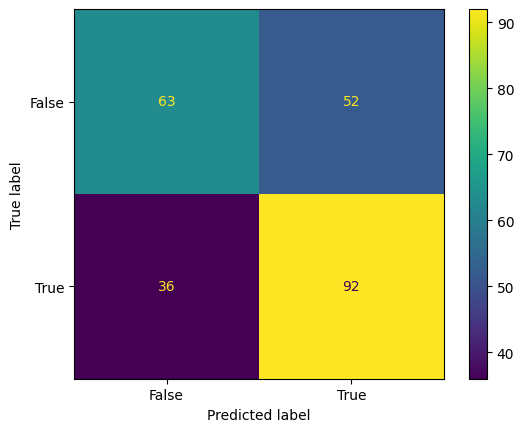

In [24]:
import numpy as np
 
from sklearn.metrics import confusion_matrix
from sklearn import metrics
# Predict probabilities for the validation data
 
y_pred_prob = binary_model.predict(val_generator)
# Convert probabilities to binary predictions (0 or 1)
 
y_pred = np.round(y_pred_prob).flatten()
# Get true labels from the validation generator
 
y_true = val_generator.classes
confusion_matrix = metrics.confusion_matrix(y_true, y_pred)
 
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
 
cm_display.plot()
plt.show()

GRAPH TRAINING AND VALIDATION CURVE

VALIDATION ACCURACY

In [25]:
import tensorflow as tf

# Evaluate the model on the validation dataset
validation_loss, validation_accuracy = binary_model.evaluate(val_generator)

# Print the validation accuracy
print("Validation Accuracy:", validation_accuracy)


8/8 [==============================] - 20s 2s/step - loss: 0.6336 - binary_accuracy: 0.6379
Validation Accuracy: 0.6378600597381592


PREDICTION PART

In [26]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

# Save the trained model
binary_model.save('binary_classification_model.keras')

In [27]:
# Load the saved model
saved_model = load_model('binary_classification_model.keras')

In [28]:
import matplotlib.pyplot as plt

# Load the test image
test_image_path = '/kaggle/working/class/benign/1-120.jpg'
test_image = image.load_img(test_image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
test_image_array = image.img_to_array(test_image)
test_image_array = np.expand_dims(test_image_array, axis=0)
test_image_array /= 255.0  # Rescale to [0, 1]

In [29]:
predictions = saved_model.predict(test_image_array)

# Get the predicted class index
predicted_class_index = tf.argmax(predictions, axis=1).numpy()[0]

# Define class labels (e.g., benign and malignant)
class_labels = ['malignant', 'benign']

# Get the predicted class label based on the index
predicted_class_label = class_labels[predicted_class_index]

# Print the predicted class label
print("Predicted class:", predicted_class_label)


1/1 [==============================] - 1s 1s/step
Predicted class: malignant
